In [1]:
import pandas as pd
from torch import Tensor
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt



In [2]:
import yfinance as yf
# Get last 5 years of Apple stock data
data = yf.download("AAPL", start="2020-01-01", end="2024-01-01")

[*********************100%***********************]  1 of 1 completed


In [3]:
data.tail()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2023-12-22,191.788803,193.581867,191.164692,193.354008,37149600
2023-12-26,191.243896,192.076034,191.025954,191.798655,28919300
2023-12-27,191.342957,191.689688,189.302232,190.689143,48087700
2023-12-28,191.768936,192.838834,191.362768,192.323695,34049900
2023-12-29,190.728760,192.581260,189.936241,192.085938,42672100


In [4]:
df = data.reset_index()['Close']
df[:10]

Ticker,AAPL
0,72.468269
1,71.763710
2,72.335564
3,71.995361
4,73.153481
5,74.707336
6,74.876221
7,76.475914
8,75.443245
9,75.119934


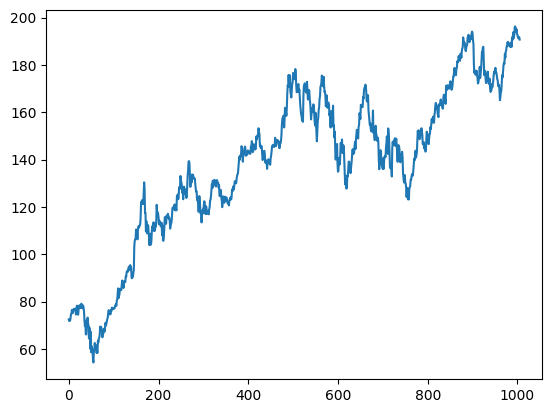

In [5]:
plt.plot(df)

In [6]:
# applying MinMax Scalar
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
print(scaler.fit(df))
print(scaler.data_max_)
df = scaler.transform(df)
df = torch.tensor(df)

# brought every value in between 0 and 1

MinMaxScaler()
[196.25657654]


In [7]:
print(f"{len(df)} , {df.max()} , {df.min()} , {df.dtype}")
print(type(df))

1006 , 1.0 , 0.0 , torch.float64
<class 'torch.Tensor'>


In [8]:
def create_dataset(data:Tensor,window_size:30) -> tuple[Tensor,Tensor]:
    """
        input :- data , window_size -> sequence Length
        output :- x_tensor (num_samples,seq_len,1)
                ,y_tensor (num_samples,1)
    
    """
    if len(data.shape) == 1:
        data = data.unsqueeze(1)
    
    x = []
    y = []
    
    for i in range(len(data) - window_size):
        
        feature = data[i:i+window_size]
        target = data[i+window_size]
        
#         print(feature.shape , target.shape)
        
        x.append(feature)
        y.append(target)
        
# Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting 
# the list to a single numpy.ndarray with numpy.array() before converting to a tenso
#     x_tensor = torch.tensor(x)
#     y_tensor = torch.tensor(y)
    
    x_tensor = torch.stack(x)
    y_tensor = torch.stack(y)

    return x_tensor , y_tensor

In [9]:
x_train , y_train = create_dataset(df,15)
x_train = x_train.float()
y_train = y_train.float()

In [10]:
print(x_train.shape,y_train.shape)
print(x_train.dtype)

torch.Size([991, 15, 1]) torch.Size([991, 1])
torch.float32


In [15]:
class LSTM(nn.Module):
    
    # assuming batch_size will be first
    def __init__(self,input_size,hidden_size,num_layers = 1,bias = True):
        
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,bias,batch_first = True)
                
        # Decoder fully connected layer
        
        self.fc = nn.Linear(hidden_size,1)
        
    def forward(self, x:Tensor , initial_state : tuple[Tensor,Tensor]):
        
#         print(x.shape,len(initial_state))
        
        out , (ht,ct) = self.lstm(x,initial_state)
        
        # out has every layers final output
#         print(out.shape)
#         print(out[:,-1,:].shape)
        
        prediction = self.fc(out[:,-1,:])
        
        return prediction

In [12]:
# Hyperparams
input_size = 1 # feature is one and sequence is 15(days) here
hidden_size = 64
num_layers = 2
epochs = 100
batch_size = 32


In [16]:
model = LSTM(input_size=input_size,
             hidden_size=hidden_size,
             num_layers=num_layers)

In [17]:
lossi = []

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

for epoch in range(epochs):
    
    # high,(shape) and low is 0
    idx = torch.randint(x_train.shape[0],(batch_size,))
    
    x_batch = x_train[idx] 
    y_batch = y_train[idx]
    
#     print(x_batch.shape,y_batch.shape) # batch_size,seq_len,1 -> batch_size,1
    
    h_not = torch.zeros(num_layers,batch_size,hidden_size) # batch_size should be in between only 
    c_not = torch.zeros(num_layers,batch_size,hidden_size)
    
    pred = model(x_batch,(h_not,c_not))
    
    loss = loss_fn(pred,y_batch)
    lossi.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

#     break

Epoch [10/100], Loss: 0.068859
Epoch [20/100], Loss: 0.043623
Epoch [30/100], Loss: 0.005715
Epoch [40/100], Loss: 0.009155
Epoch [50/100], Loss: 0.010262
Epoch [60/100], Loss: 0.002706
Epoch [70/100], Loss: 0.001689
Epoch [80/100], Loss: 0.001341
Epoch [90/100], Loss: 0.001712
Epoch [100/100], Loss: 0.001740


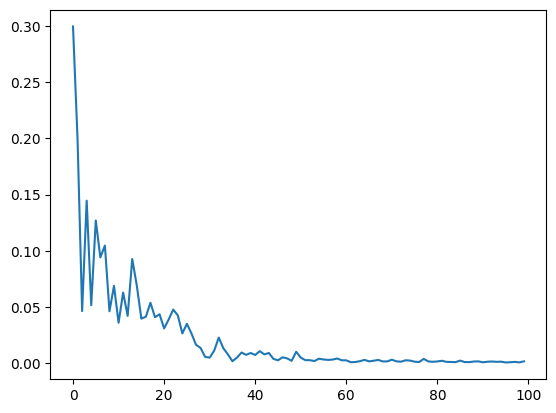

In [18]:
plt.plot(lossi)